# WeatherPy
----

Written in the Python 3.7.9 Environment

By Nicole Lund 

In partnership with Anne Niemiec.

The starter code and pseudo code for this challenge was provided and can be reviewed in python-api-challenge\assignment_source_files

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key
if weather_api_key == "YOUR KEY HERE!":
    import sys
    sys.path.append(r"C:\Users\nlund\Documents\GitHub\untracked_files")
    from untracked_api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
# Define function for calculating linear regressions
def regress_line(x,y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    y_regress = x * slope + intercept
    line_text = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    print(f"The r-value is: {rvalue ** 2}")
    return y_regress, line_text

## Determine user's preferred data source

In [3]:
# Determine if user would like to load pre-populated weather data or
get_current_wx = input("Would you like to analyze current weather conditions (Y/N)?")

# If no, load provided data
if get_current_wx == "N":
    print("The user opted to load pre-populated weather data")
    input_file = "input_data\cities.csv"
    df_wx_data = pd.read_csv(input_file)
elif get_current_wx == "Y":
    print("The user opted to analyze current weather conditions")
else:
    print("The user chose an invalid option.")
    raise SystemExit("Stop executing notebook") 

The user opted to analyze current weather conditions


## Generate Cities List

In [4]:
if get_current_wx == "Y":
    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
        
        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    print(len(cities))
else:
    print(len(df_wx_data))

610


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
if get_current_wx == "Y":
    # Setup and call weather API

    # Save config information.
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"

    # Build partial query URL
    query_url = f"{url}appid={weather_api_key}&units={units}&q="

    # set up lists to hold reponse info
    city_list = []
    lat_list = []
    lon_list = []
    max_temp_list = []
    humidity_list = []
    cloudiness_list = []
    wndspd_list = []
    country_list = []
    date_list = []
    call_counter = 1
    call_set = 1

    # Collect weather data using json api calls
    print('Beginning Data Retrieval')     
    print('-----------------------------')

    # Loop through the list of cities and perform a request for data on each and populate data lists
    for city in cities:
        response = requests.get(query_url + city).json()
        #print(json.dumps(response, indent=4, sort_keys=True))

        try:
            city_list.append(response['name'])
            lat_list.append(response['coord']['lat'])
            lon_list.append(response['coord']['lon'])
            max_temp_list.append(response['main']['temp_max'])
            humidity_list.append(response['main']['humidity'])
            cloudiness_list.append(response['clouds']['all'])
            wndspd_list.append(response['wind']['speed'])
            country_list.append(response['sys']['country'])
            date_list.append(response['dt'])

            print(f'Processing Record {call_counter} of Set {call_set} | {city}')

        except KeyError:
            print("City not found. Skipping...")

        if call_counter > 49:
            call_counter = 1
            call_set += 1
            time.sleep(10)    
        else:
            call_counter += 1

    print('-----------------------------')
    print('Data Retrieval Complete')      
    print('-----------------------------')

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | qaqortoq
Processing Record 2 of Set 1 | half moon bay
City not found. Skipping...
Processing Record 4 of Set 1 | hobyo
Processing Record 5 of Set 1 | atuona
Processing Record 6 of Set 1 | kapaa
Processing Record 7 of Set 1 | usinsk
Processing Record 8 of Set 1 | campos sales
Processing Record 9 of Set 1 | seymchan
City not found. Skipping...
Processing Record 11 of Set 1 | kharagauli
Processing Record 12 of Set 1 | chokurdakh
Processing Record 13 of Set 1 | baie-comeau
Processing Record 14 of Set 1 | kudahuvadhoo
City not found. Skipping...
Processing Record 16 of Set 1 | andros
Processing Record 17 of Set 1 | bonavista
Processing Record 18 of Set 1 | barrow
Processing Record 19 of Set 1 | punta arenas
Processing Record 20 of Set 1 | mataura
Processing Record 21 of Set 1 | busselton
Processing Record 22 of Set 1 | pacific grove
Processing Record 23 of Set 1 | port alfred
Processing Record 24 of Set 1 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [6]:
if get_current_wx == "Y":
    df_wx_data = pd.DataFrame({
        "City": city_list,
        "Lat": lat_list,
        "Lng": lon_list,
        "Max Temp": max_temp_list,
        "Humidity": humidity_list,
        "Cloudiness": cloudiness_list,
        "Wind Speed": wndspd_list,
        "Country": country_list,
        "Date": date_list})
else:
    df_wx_data = df_wx_data.loc[:,["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_wx_data.to_csv(output_data_file)
df_wx_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Qaqortoq,60.7167,-46.0333,50.00,29,20,11.50,GL,1619132249
1,Half Moon Bay,37.4636,-122.4286,62.01,87,75,6.91,US,1619132459
2,Hobyo,5.3505,48.5268,83.53,71,77,11.59,SO,1619132459
3,Atuona,-9.8000,-139.0333,80.82,76,49,19.53,PF,1619132460
4,Kapaa,22.0752,-159.3190,81.00,73,20,9.22,US,1619132460
...,...,...,...,...,...,...,...,...,...
550,Rodrigues Alves,-7.7380,-72.6509,86.00,74,20,1.88,BR,1619132776
551,Villamontes,-21.2500,-63.5000,73.85,88,93,0.25,BO,1619132777
552,Vila,42.0304,-8.1588,51.01,91,82,4.43,PT,1619132777
553,Port-Gentil,-0.7193,8.7815,77.58,86,100,13.51,GA,1619132778


### Display summary statistics on the weather DataFrame

In [7]:
df_wx_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,5.550000e+02
mean,20.949275,17.236401,59.300973,69.796396,57.560360,8.277171,1.619133e+09
std,33.239313,88.715684,19.796686,22.422349,37.011676,5.808714,1.190352e+02
min,-54.800000,-179.166700,0.910000,6.000000,0.000000,0.250000,1.619132e+09
25%,-7.303450,-59.126750,44.010000,59.000000,20.000000,3.790000,1.619133e+09
50%,26.326000,20.226300,62.600000,76.000000,74.000000,6.910000,1.619133e+09
75%,49.054050,93.038350,76.975000,87.000000,90.500000,11.500000,1.619133e+09
max,78.218600,179.316700,93.200000,100.000000,100.000000,41.630000,1.619133e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
#  Check for cities that have humidity over 100%.
df_invalid_humidity = df_wx_data.loc[df_wx_data["Humidity"] > 100, ["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_invalid_humidity

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date


In [9]:
# Remove invalid humidity data
df_wx_data_clean = df_wx_data.loc[df_wx_data["Humidity"] <= 100, ["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_wx_data_clean.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,5.550000e+02
mean,20.949275,17.236401,59.300973,69.796396,57.560360,8.277171,1.619133e+09
std,33.239313,88.715684,19.796686,22.422349,37.011676,5.808714,1.190352e+02
min,-54.800000,-179.166700,0.910000,6.000000,0.000000,0.250000,1.619132e+09
25%,-7.303450,-59.126750,44.010000,59.000000,20.000000,3.790000,1.619133e+09
50%,26.326000,20.226300,62.600000,76.000000,74.000000,6.910000,1.619133e+09
75%,49.054050,93.038350,76.975000,87.000000,90.500000,11.500000,1.619133e+09
max,78.218600,179.316700,93.200000,100.000000,100.000000,41.630000,1.619133e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [10]:
# Extract data collection date
pretty_date = []
for idx, row in df_wx_data_clean.iterrows():
    data_time = time.localtime(row["Date"])
    pretty_date.append(f"{data_time.tm_mon}/{data_time.tm_mday}/{data_time.tm_year}")

collection_date = str(set(pretty_date)).strip("{'}")
print(f"Data collected on {collection_date}")

Data collected on 4/22/2021


## Latitude vs. Temperature Plot

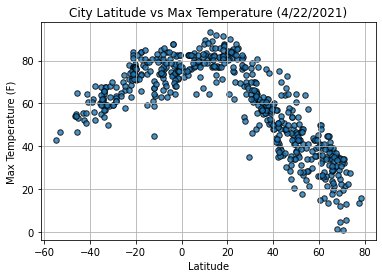

In [11]:
df_wx_data_clean.plot(
    "Lat","Max Temp",
    title=f"City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig("output_data/lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Max temperature plot shows the latitude for each city vs the maximum temperature seen that day.

## Latitude vs. Humidity Plot

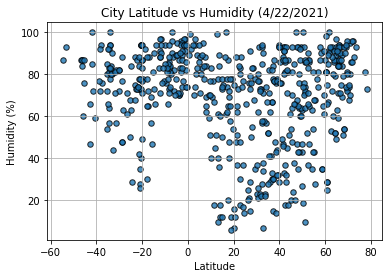

In [12]:
df_wx_data_clean.plot(
    "Lat","Humidity",
    title=f"City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("output_data/lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Humidity plot shows the latitude for each city vs the current humidity.

## Latitude vs. Cloudiness Plot

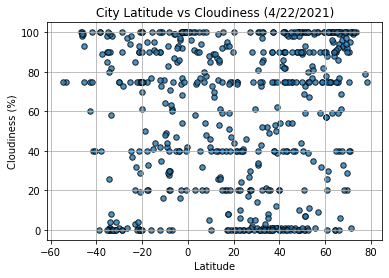

In [13]:
df_wx_data_clean.plot(
    "Lat","Cloudiness",
    title=f"City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig("output_data/lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Cloudiness plot shows the latitude for each city vs the percentage of the sky currently covered by clouds.

## Latitude vs. Wind Speed Plot

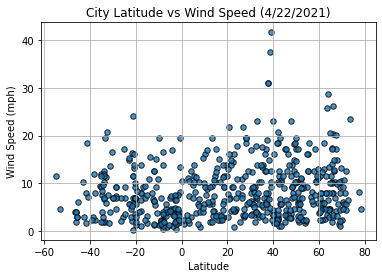

In [14]:
df_wx_data_clean.plot(
    "Lat","Wind Speed",
    title=f"City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig("output_data/lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Wind Speed plot shows the latitude for each city vs the current wind speed.

## Linear Regression

Create separate figures for each hemisphere
* Northern hemisphere
* Southern hemisphere

In [15]:
# Collect data by northern and southern hemispheres
df_wx_data_clean_N_hemi = df_wx_data_clean.loc[df_wx_data_clean["Lat"]>=0]
df_wx_data_clean_S_hemi = df_wx_data_clean.loc[df_wx_data_clean["Lat"]<0]
df_wx_data_clean_S_hemi

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
3,Atuona,-9.8000,-139.0333,80.82,76,49,19.53,PF,1619132460
6,Campos Sales,-7.0744,-40.3761,69.73,90,61,3.80,BR,1619132461
15,Punta Arenas,-53.1500,-70.9167,46.40,93,75,4.61,CL,1619132465
16,Mataura,-46.1927,168.8643,54.00,87,98,4.00,NZ,1619132465
17,Busselton,-33.6500,115.3333,57.00,84,82,1.99,AU,1619132465
...,...,...,...,...,...,...,...,...,...
546,Cap Malheureux,-19.9842,57.6142,75.99,87,100,3.00,MU,1619132775
547,Neuquén,-38.9516,-68.0591,60.80,77,0,2.30,AR,1619132735
550,Rodrigues Alves,-7.7380,-72.6509,86.00,74,20,1.88,BR,1619132776
551,Villamontes,-21.2500,-63.5000,73.85,88,93,0.25,BO,1619132777


### Latitude vs. Temperature Plots with linear regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.7987106943959591


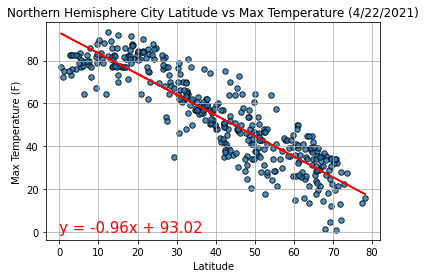

In [16]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Max Temp"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Max Temp",
    title=f"Northern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(0,0),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/north_lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Max Temperature as Latitude increases from the Equator. The slope of the linear regression is negative indicating that the Max Temperature decreases as Latitude increases.  The r-value indicates relatively high correlation.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.49518750956007174


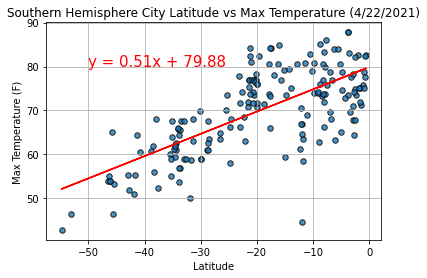

In [18]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Max Temp"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Max Temp",
    title=f"Southern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-50,80),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/south_lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Max Temperature as Latitude increases from the South Pole. The slope of the linear regression is positive indicating that the Max Temperature increase as Latitude increases.  The r-value indicates moderate correlation.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.03495546865452388


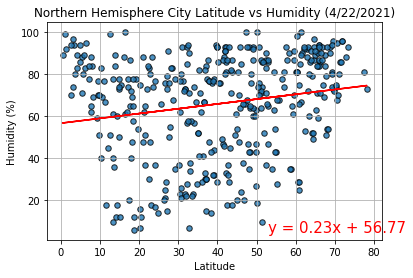

In [20]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Humidity"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Humidity",
    title=f"Northern Hemisphere City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(53,5),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.savefig("output_data/north_lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Humidity as Latitude increases from the Equator. The slope of the linear regression is very small with a wide scatter in the data points indicating that there is little correlation between Latitude and Humidity.  The small r-value corroborates this result.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.0314951312204026


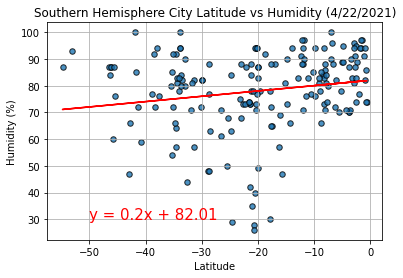

In [22]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Humidity"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Humidity",
    title=f"Southern Hemisphere City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-50,30),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.savefig("output_data/south_lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Humidity as Latitude increases from the South Pole. The slope of the linear regression is very small with a wide scatter in the data points indicating that there is little correlation between Latitude and Humidity.  The small r-value corroborates this result.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.04237074826874424


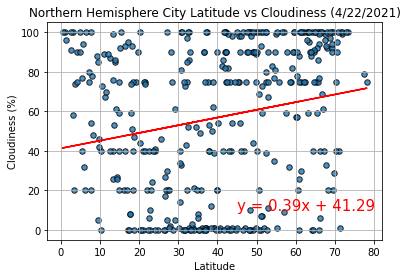

In [23]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Cloudiness"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Cloudiness",
    title=f"Northern Hemisphere City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(45,10),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.savefig("output_data/north_lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Cloudiness as Latitude increases from the Equator. There is wide scatter in the data points around the regression line indicating that there is little correlation between Latitude and Cloudiness.  The small r-value corroborates this result.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.00493772684442401


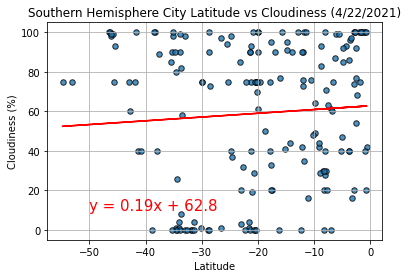

In [24]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Cloudiness"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Cloudiness",
    title=f"Southern Hemisphere City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-50,10),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.savefig("output_data/south_lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Cloudiness as Latitude increases from the South Pole. There is wide scatter in the data points around the regression line indicating that there is little correlation between Latitude and Cloudiness.  The small r-value corroborates this result.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.004786537452546956


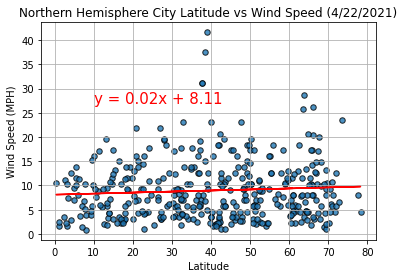

In [26]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Wind Speed"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Wind Speed",
    title=f"Northern Hemisphere City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(10,27),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (MPH)")

plt.savefig("output_data/north_lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Wind Speed as Latitude increases from the Equator. There is wide scatter in the data points around the regression line indicating that there is little correlation between Latitude and Wind Speed.  The small r-value corroborates this result.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.023625857193437166


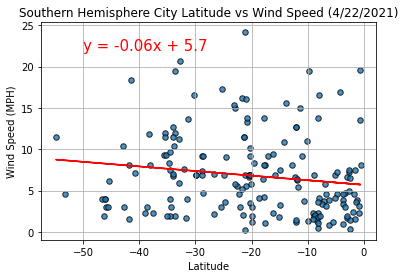

In [28]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Wind Speed"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Wind Speed",
    title=f"Southern Hemisphere City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-50,22),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (MPH)")

plt.savefig("output_data/south_lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Wind Speed as Latitude increases from the South Pole. There is wide scatter in the data points around the regression line indicating that there is little correlation between Latitude and Wind Speed.  The small r-value corroborates this result.